In [1]:
import matplotlib as mpl
from utils import plot
import matplotlib.pyplot as plt
import numpy as np
import _pickle as pkl
import scipy.stats as stats
import tensorflow as tf
import time
from utils import dataReader, get_session, integrated_gradients, softmax, entropy, pct1pct, gini
from model import Model

/nobackup/ENV/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nobackup/ENV/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nobackup/ENV/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nobackup/ENV/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (

In [2]:
X, y = dataReader()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Image ID: 900, Image Label : 1


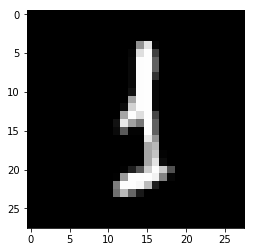

In [3]:
n = 900
original_label = y[n]
test_image = X[n]
plt.rcParams["figure.figsize"]=8,8
print("Image ID: {}, Image Label : {}".format(n, y[n]))
%matplotlib inline
plt.imshow(X[n,:,:,0], cmap='gray')

In [4]:
reference_image = np.zeros((28, 28, 1), dtype=np.float32)
num_steps = 100

# Natural Training

In [5]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/nat_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from models/nat_trained/checkpoint-24900


In [6]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(np.argmax(nat_pred), np.max(nat_pred)))

prediction: 1, confidence: 0.9721893668174744


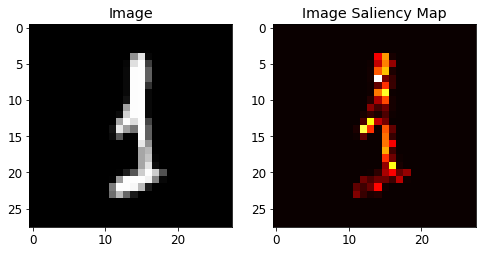

In [7]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
nat_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(nat_saliency, cmap="hot")

In [8]:
ent = entropy(IG.flatten())
print('The entropy for IG is:', ent)

a1p = pct1pct(IG.flatten())
print('The A1P for IG is:', a1p)

gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The entropy for IG is: 0.5818222554905639
The A1P for IG is: 0.09438775510204081
The Gini for IG is: 0.9538787560927822


# Adversarial Traininig

In [9]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/adv_trained'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from models/adv_trained/checkpoint-99900


In [10]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(np.argmax(nat_pred), np.max(nat_pred)))

prediction: 1, confidence: 0.8960168361663818


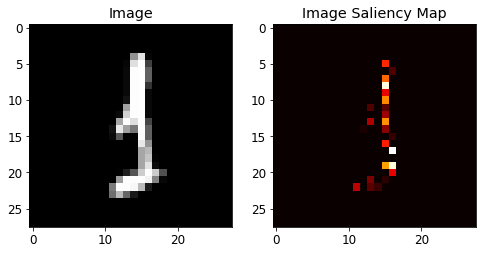

In [11]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
adv_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(adv_saliency, cmap="hot")

In [12]:
ent = entropy(IG.flatten())
print('The entropy for IG is:', ent)

a1p = pct1pct(IG.flatten())
print('The A1P for IG is:', a1p)

gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The entropy for IG is: 0.4283784779918379
The A1P for IG is: 0.030612244897959183
The Gini for IG is: 0.9830495069240033


# L1 Norm Regularization 

In [13]:
tf.reset_default_graph()
sess = get_session()
model = Model()
# restore models
model_dir = 'models/nat_trained_with_l1_reg'

saver = tf.train.Saver()
checkpoint = tf.train.latest_checkpoint(model_dir)
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from models/nat_trained_with_l1_reg/checkpoint-24900


In [14]:
nat_output = sess.run(model.output, feed_dict={model.input: [test_image]})
nat_pred = softmax(nat_output)

print('prediction: {}, confidence: {}'.format(np.argmax(nat_pred), np.max(nat_pred)))

prediction: 1, confidence: 0.6459177136421204


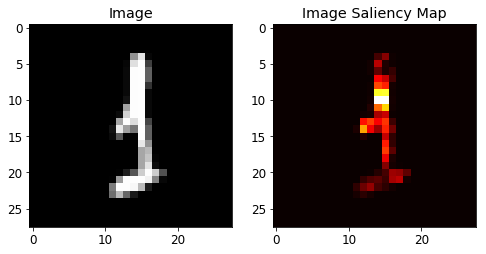

In [15]:
IG = integrated_gradients(sess, reference_image, test_image, original_label, model, gradient_func='output_input_gradient', steps=num_steps)

mpl.rcParams["figure.figsize"]=8,8
plt.rc("text",usetex=False)
plt.rc("font",family="sans-serif",size=12)
saliency = np.sum(np.abs(IG),-1)
l1_saliency = 28*28*saliency/np.sum(saliency)
plt.subplot(1,2,1)
plt.title("Image")
image = X[n,:,:,0]
plt.imshow(image, cmap='gray')
plt.subplot(1,2,2)
plt.title("Image Saliency Map")
plt.imshow(l1_saliency, cmap="hot")

In [16]:
ent = entropy(IG.flatten())
print('The entropy for IG is:', ent)

a1p = pct1pct(IG.flatten())
print('The A1P for IG is:', a1p)

gini_v = gini(IG.flatten())
print('The Gini for IG is:', gini_v)

The entropy for IG is: 0.5698061098816648
The A1P for IG is: 0.09566326530612244
The Gini for IG is: 0.9575553603148713


# Save Figures

In [17]:
import os

save_figure_dir = os.path.join('demo_figures', 'IG', str(n))

if not os.path.exists(save_figure_dir):
    os.makedirs(save_figure_dir)
    

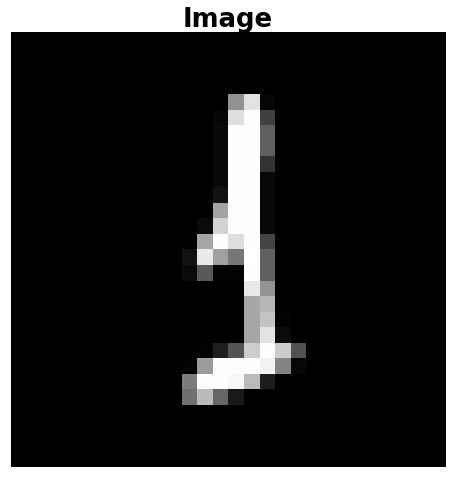

In [18]:
axis = plot(image, cmap='gray')
axis.title('Image', fontsize=26, fontweight="bold")
axis.savefig(os.path.join(save_figure_dir, 'image.jpg'), bbox_inches='tight', pad_inches = 0)

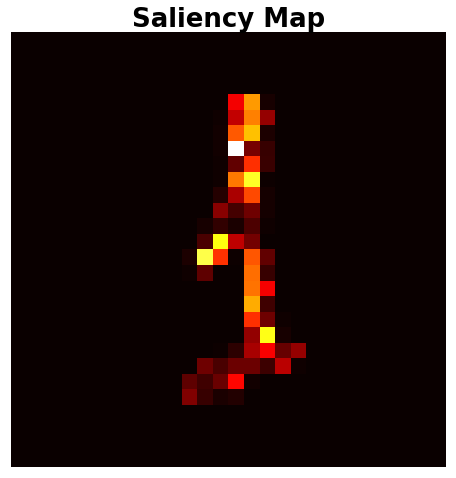

In [19]:
axis = plot(nat_saliency, cmap='hot')
axis.title('Saliency Map', fontsize=26, fontweight="bold")
axis.savefig(os.path.join(save_figure_dir, 'nat_saliency_map.jpg'), bbox_inches='tight', pad_inches = 0)

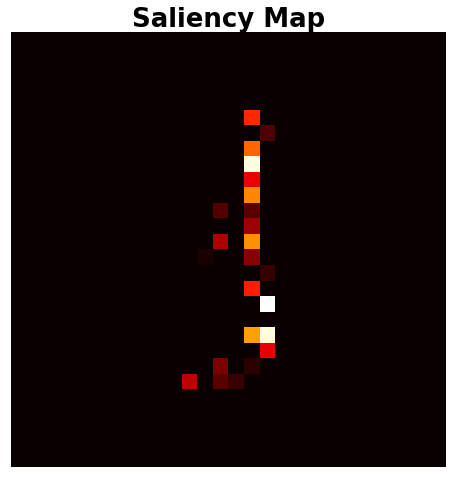

In [20]:
axis = plot(adv_saliency, cmap='hot')
axis.title('Saliency Map', fontsize=26, fontweight="bold")
axis.savefig(os.path.join(save_figure_dir, 'adv_saliency_map.jpg'), bbox_inches='tight', pad_inches = 0)

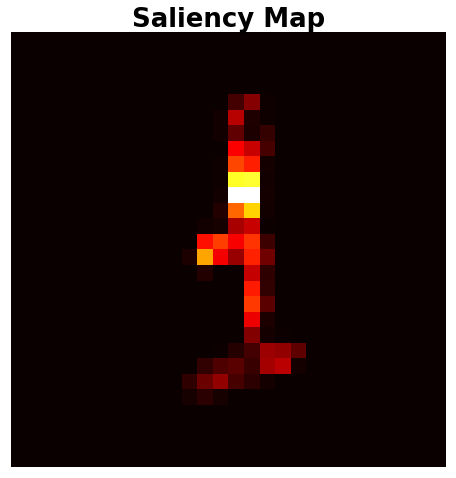

In [21]:
axis = plot(l1_saliency, cmap='hot')
axis.title('Saliency Map', fontsize=26, fontweight="bold")
axis.savefig(os.path.join(save_figure_dir, 'l1_saliency_map.jpg'), bbox_inches='tight', pad_inches = 0)